In [46]:
from __future__ import print_function, division

import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import shutil
import warnings
import matplotlib.image as mpimg
warnings.filterwarnings("ignore")

plt.ion() 

In [47]:
torch.__version__

'1.10.1'

In [5]:
timm.__version__

'0.5.4'

In [6]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## Cleaning data

In [7]:
SOURCE_PATH = 'C:\PythonDev\Projects\sex_clothes_classifier\data\\'

In [11]:
celebs_men = pd.read_csv(f'{SOURCE_PATH}\celeb_man.csv', sep=',', header=None)
celebs_men.columns = ['name', 'gender', 'path']
celebs_men.name[celebs_men.name=='Григориий Лепс'] = "Григорий Лепс"

list_to_delete = []
for elem in celebs_men.name.unique():
    if elem not in os.listdir(path=f'C:\PythonDev\Projects\sex_clothes_classifier\data\static\celebs'):
        list_to_delete.append(elem)

for elem in list_to_delete:
    celebs_men = celebs_men.drop(celebs_men[celebs_men['name'] == elem].index)

celebs_men.dropna(inplace=True)
celebs_men.reset_index(inplace=True)
del celebs_men['index']

In [12]:
celebs_women = pd.read_csv(f'{SOURCE_PATH}/celeb_woman.csv', sep=',', header=None)
celebs_women.columns = ['name', 'gender', 'path']
celebs_women.name[celebs_women.name=='АЛИНА КАБАЕВА'] = "Алина Кабаева"

list_to_delete = []
for elem in celebs_women.name.unique():
    if elem not in os.listdir(path=f'{SOURCE_PATH}/static/celebs/'):
        list_to_delete.append(elem)

for elem in list_to_delete:
    celebs_women = celebs_women.drop(celebs_women[celebs_women['name'] == elem].index)

celebs_women.dropna(inplace=True)
celebs_women.reset_index(inplace=True)
del celebs_women['index']

In [13]:
celebs_df = pd.concat([celebs_men, celebs_women], axis=0)
celebs_df['gender'][celebs_df['gender'] == 'мужской'] = 0
celebs_df['gender'][celebs_df['gender'] == 'женский'] = 1

<AxesSubplot:ylabel='Frequency'>

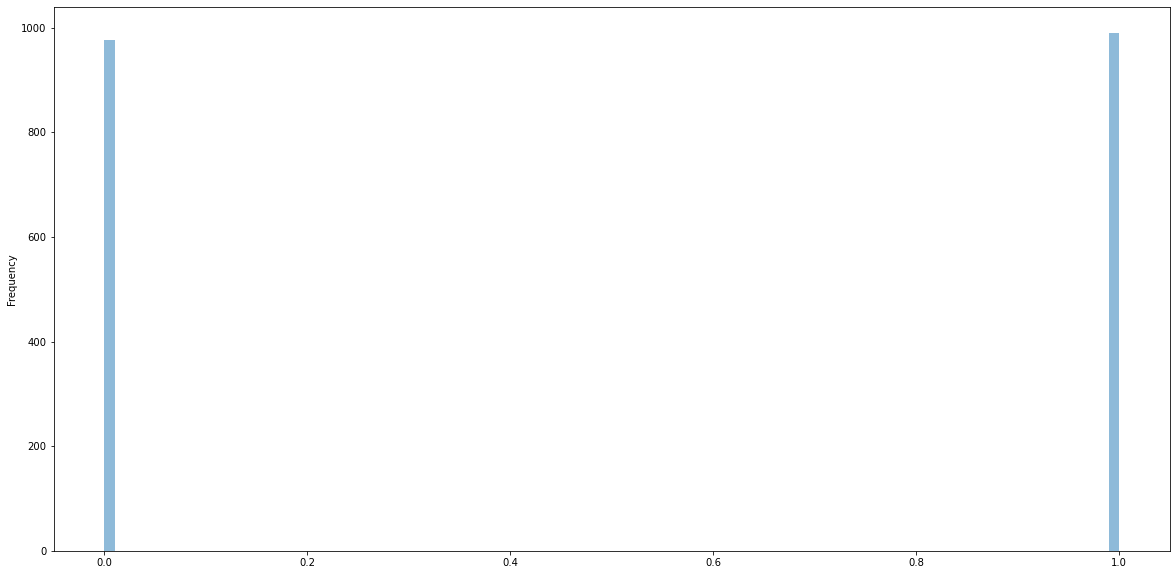

In [14]:
celebs_df.gender.plot.hist(alpha=0.5, bins=100, figsize=(20, 10))

In [18]:
for idx in range(len(celebs_men.name.unique())):
    list_files = os.listdir(path=f'C:\PythonDev\Projects\sex_clothes_classifier\data\static\celebs\{celebs_men.name.unique()[idx]}')
    for ids in range(len(list_files)):
        shutil.move(f'C:\PythonDev\Projects\sex_clothes_classifier\data\static\celebs\{celebs_men.name.unique()[idx]}/{list_files[ids]}',
                    f"C:\PythonDev\Projects\sex_clothes_classifier\data\image_celebs\men\{list_files[ids]}")

In [19]:
for idx in range(len(celebs_women.name.unique())):
    list_files = os.listdir(path=f'C:\PythonDev\Projects\sex_clothes_classifier\data\static\celebs\{celebs_women.name.unique()[idx]}')
    for ids in range(len(list_files)):
        shutil.move(f'C:\PythonDev\Projects\sex_clothes_classifier\data\static\celebs\{celebs_women.name.unique()[idx]}/{list_files[ids]}',
                    f"C:\PythonDev\Projects\sex_clothes_classifier\data\image_celebs\women\{list_files[ids]}")

In [20]:
list_files_men = os.listdir(path=f'C:\PythonDev\Projects\sex_clothes_classifier\data\image_celebs\men\\')
list_files_women = os.listdir(path=f'C:\PythonDev\Projects\sex_clothes_classifier\data\image_celebs\women\\')

In [21]:
len(list_files_men), len(list_files_women)

(3082, 5299)

In [22]:
valid_size_men = int(0.2*len(list_files_men))
valid_names_men = sorted(list_files_men)[:valid_size_men]

In [23]:
for idx in range(valid_size_men):
    shutil.move(f"C:\PythonDev\Projects\sex_clothes_classifier\data\image_celebs\men\{valid_names_men[idx]}",
                f"C:\PythonDev\Projects\sex_clothes_classifier\data\image_celebs\\valid\men\{valid_names_men[idx]}")

In [24]:
list_files_men = os.listdir(path=f'C:\PythonDev\Projects\sex_clothes_classifier\data\image_celebs\men\\')
len(list_files_men), len(list_files_women)

(2466, 5299)

In [25]:
for idx in range(len(list_files_men)):
    shutil.move(f"C:\PythonDev\Projects\sex_clothes_classifier\data\image_celebs\men\{list_files_men[idx]}",
                f"C:\PythonDev\Projects\sex_clothes_classifier\data\image_celebs\\train\\men\{list_files_men[idx]}")

In [30]:
valid_size_women = int(0.2*len(list_files_women))
valid_names_women = sorted(list_files_women)[:valid_size_women]

for idx in range(valid_size_women):
    shutil.move(f"C:\PythonDev\Projects\sex_clothes_classifier\data\image_celebs\women\{valid_names_women[idx]}",
                f"C:\PythonDev\Projects\sex_clothes_classifier\data\image_celebs\\valid\women\{valid_names_women[idx]}")

In [31]:
list_files_women = os.listdir(path=f'C:\PythonDev\Projects\sex_clothes_classifier\data\image_celebs\women\\')
len(list_files_men), len(list_files_women)

(2466, 3392)

In [32]:
for idx in range(len(list_files_women)):
    shutil.move(f"C:\PythonDev\Projects\sex_clothes_classifier\data\image_celebs\women\\{list_files_women[idx]}",
                f"C:\PythonDev\Projects\sex_clothes_classifier\data\image_celebs\\train\women\{list_files_women[idx]}")

# Dataloader

In [34]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'C:\PythonDev\Projects\sex_clothes_classifier\data\image_celebs'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

In [35]:
dataloader_train = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=4) for x in ['train']}
dataloader_valid = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=4) for x in ['valid']}
dataloaders = {**dataloader_train, **dataloader_valid}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [36]:
image_datasets['train'].classes

['men', 'women']

In [37]:
dataset_sizes

{'train': 5858, 'valid': 2523}

In [38]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10, 8))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

In [39]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [41]:
model_mobilenet_celeb = models.mobilenet_v2(pretrained=False)
model_mobilenet_celeb.classifier[1] = nn.Linear(in_features=1280, out_features=2, bias=True)
model_mobilenet_celeb.load_state_dict(torch.load("C:\PythonDev\Projects\sex_clothes_classifier\weights\gender_classifier_lite_v_2.pth"))
model_mobilenet_celeb = model_mobilenet_celeb.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_mobilenet_celeb.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [36]:
model_mobilenet_celeb = train_model(model_mobilenet_celeb, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.2883 Acc: 0.9351
valid Loss: 0.1885 Acc: 0.9516

Epoch 1/4
----------
train Loss: 0.1002 Acc: 0.9688
valid Loss: 0.1444 Acc: 0.9594

Epoch 2/4
----------
train Loss: 0.0671 Acc: 0.9791
valid Loss: 0.1243 Acc: 0.9660

Epoch 3/4
----------
train Loss: 0.0487 Acc: 0.9852
valid Loss: 0.1101 Acc: 0.9678

Epoch 4/4
----------
train Loss: 0.0404 Acc: 0.9884
valid Loss: 0.1057 Acc: 0.9696

Training complete in 7m 10s
Best val Acc: 0.969552


In [42]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10, 8))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [43]:
def visualize_model(model, num_images=12):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                # ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j], title=f"predicted: {class_names[preds[j]]}")

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [44]:
torch.save(model_mobilenet_celeb.state_dict(), 'gender_classifier_lite_v_celebs.pth')

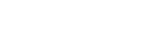

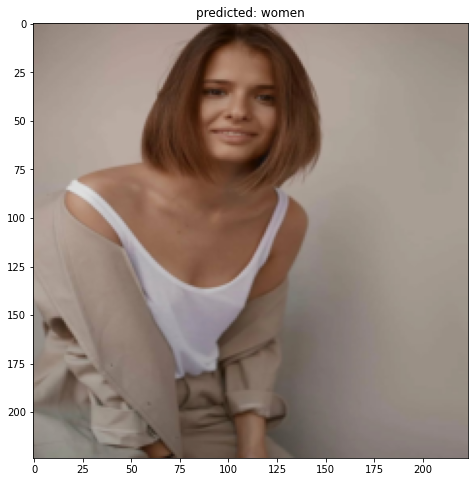

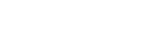

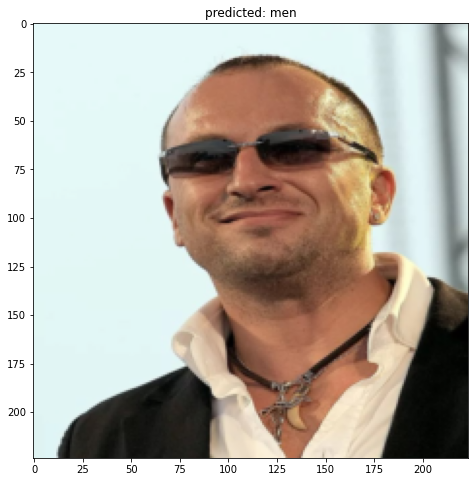

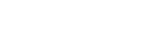

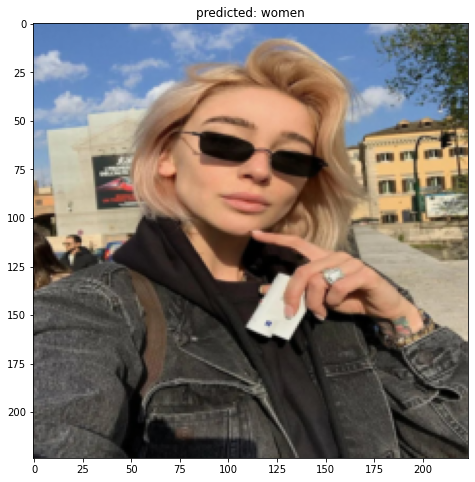

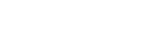

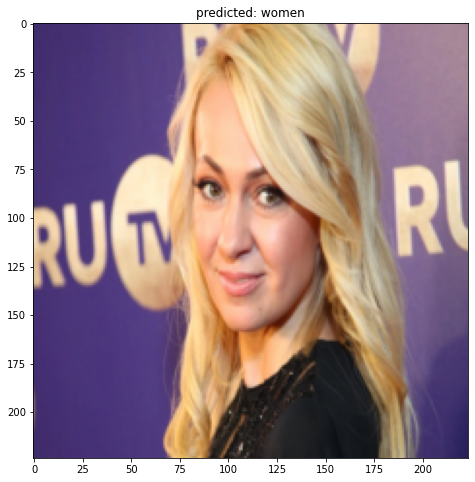

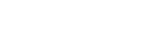

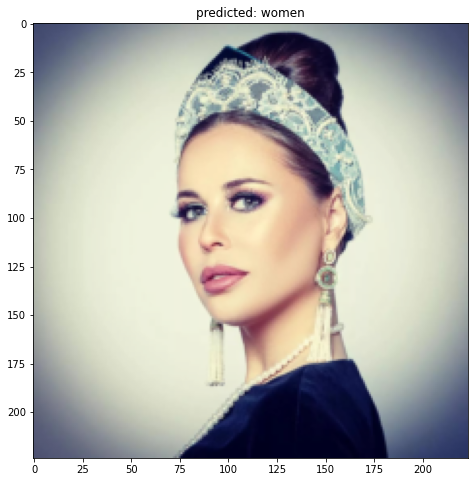

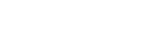

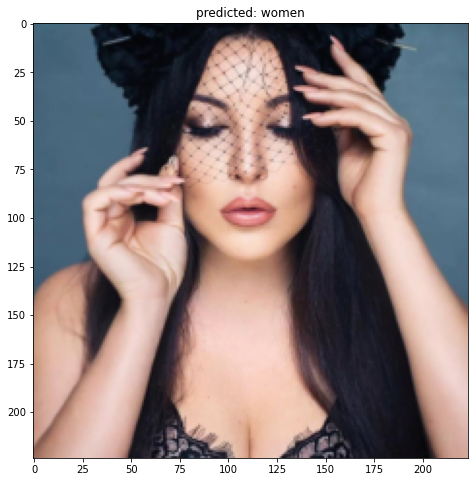

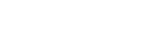

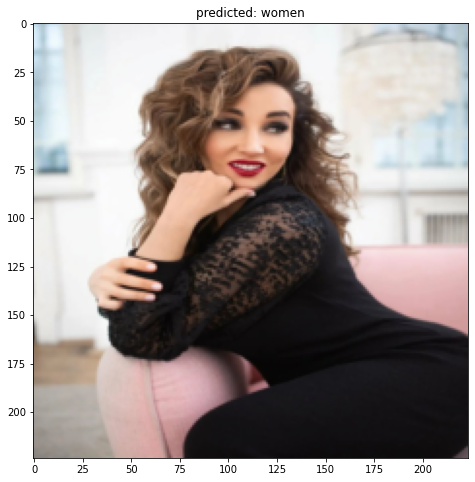

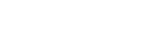

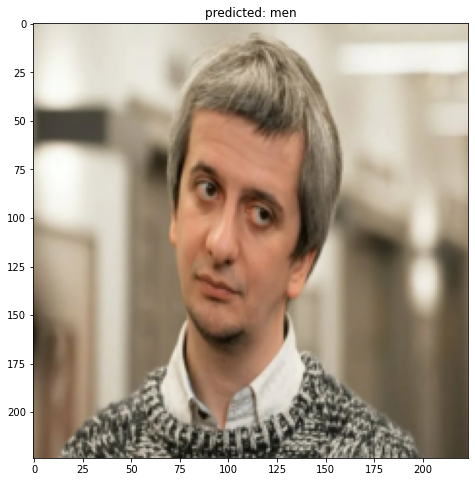

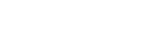

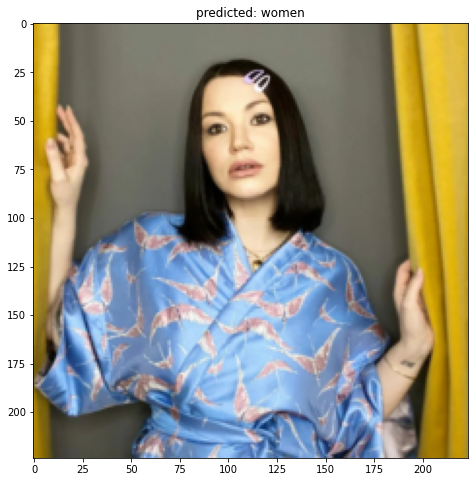

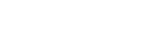

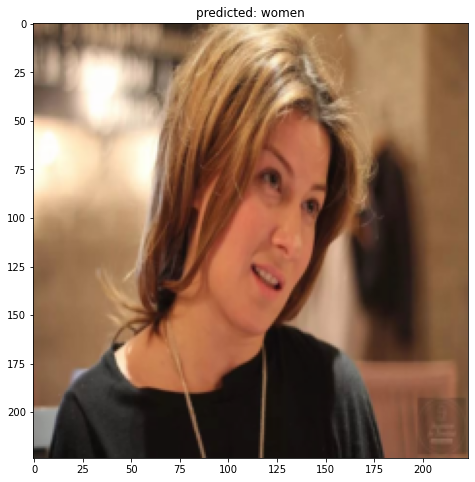

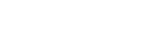

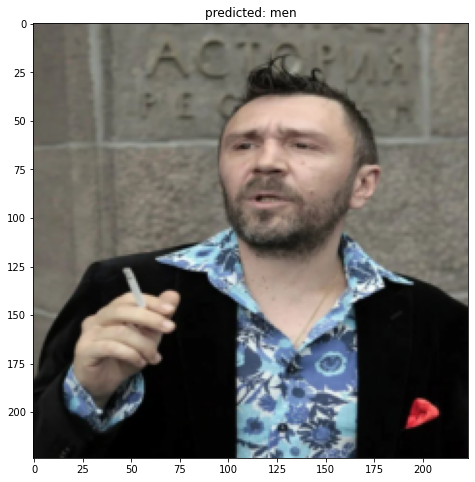

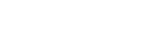

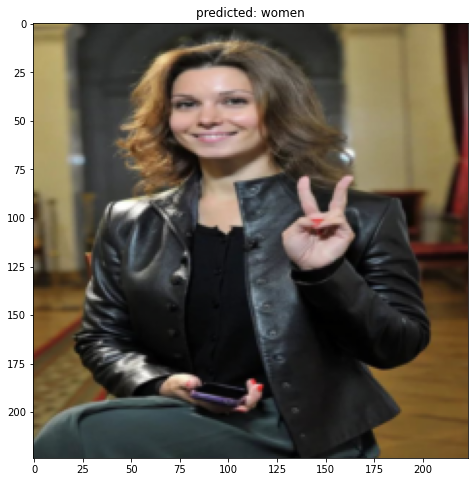

In [45]:
visualize_model(model_mobilenet_celeb)

## Quantization

In [42]:
from torch.quantization import convert
model_mobilenet_celeb_quantized = convert(model_mobilenet_celeb, inplace=False)

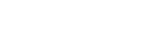

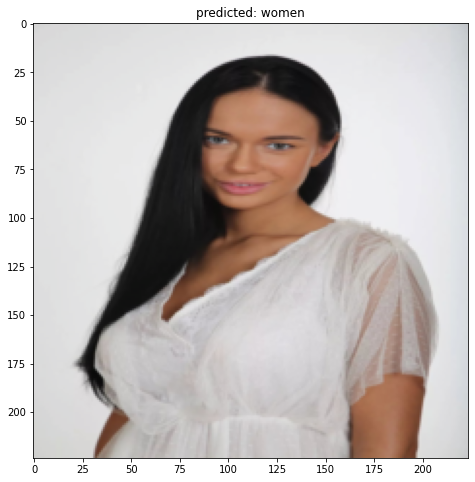

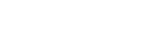

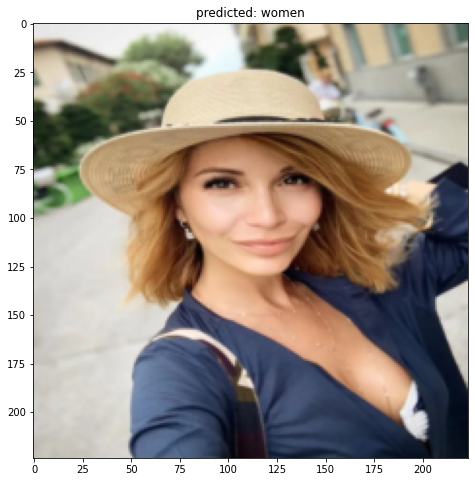

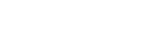

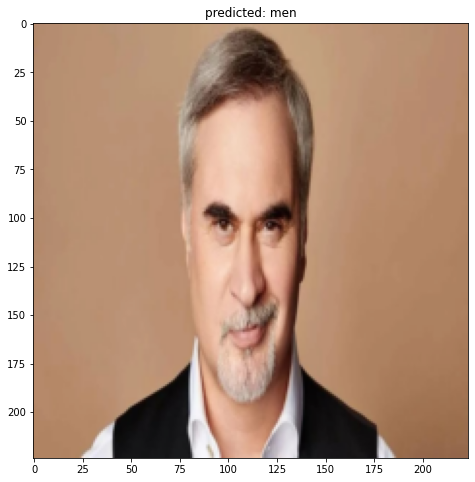

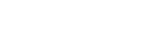

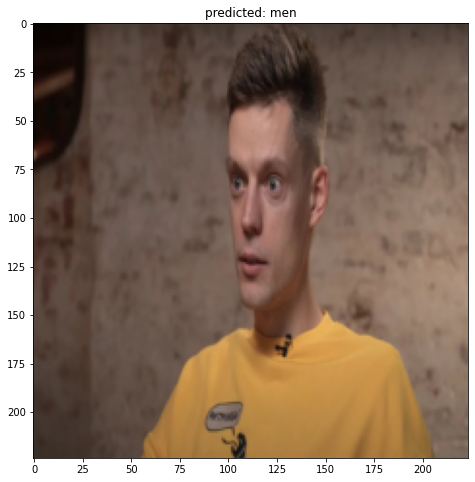

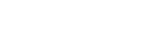

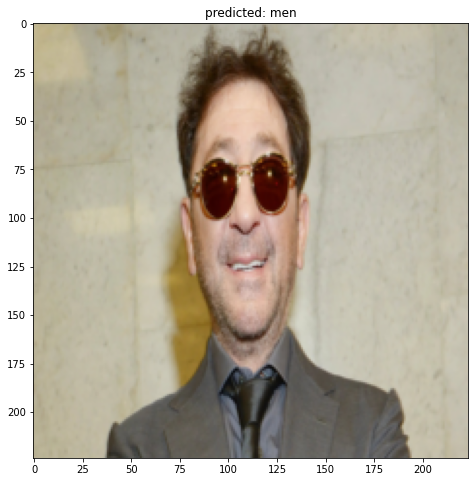

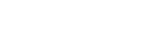

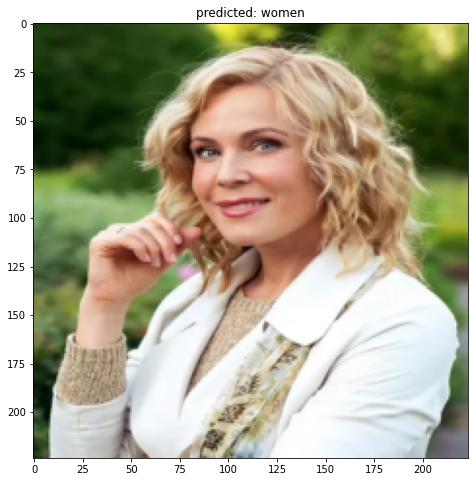

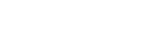

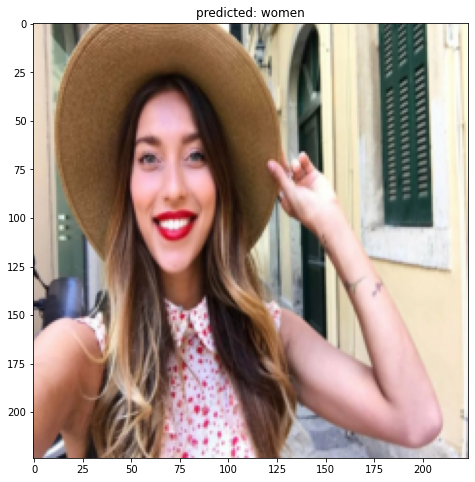

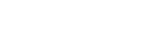

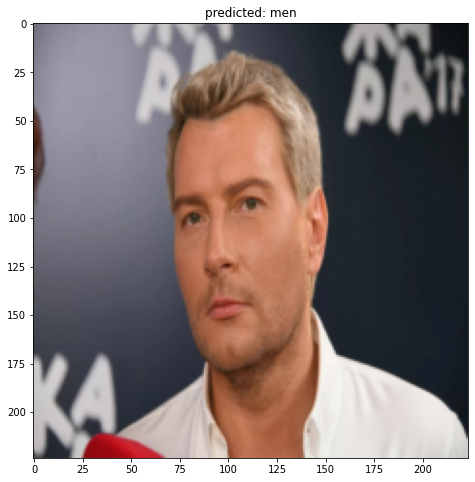

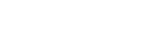

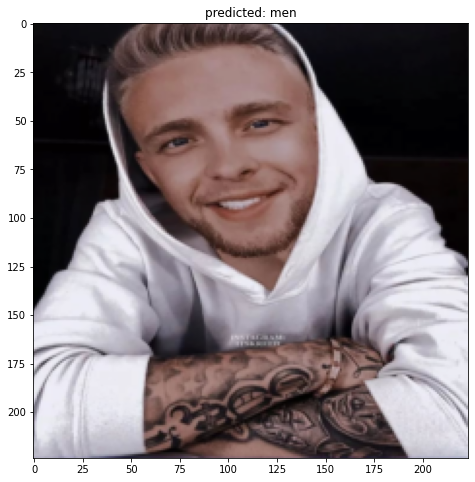

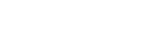

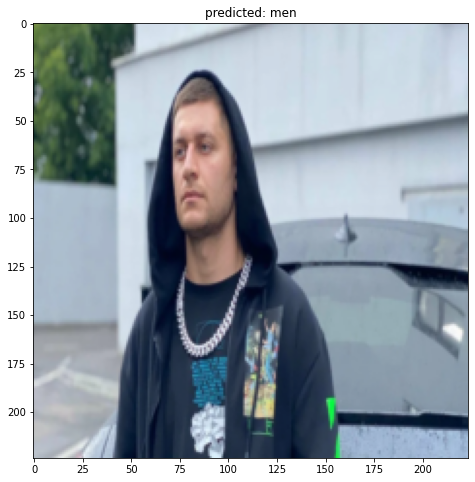

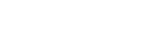

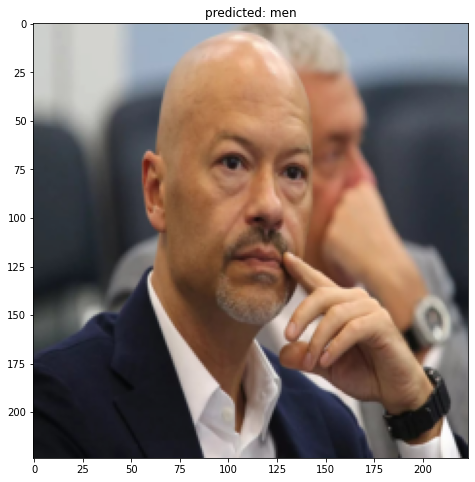

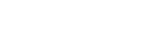

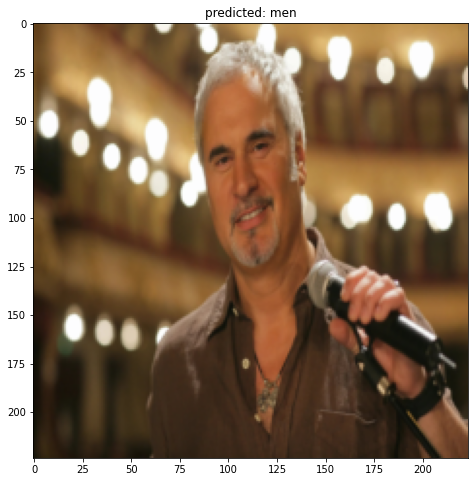

In [43]:
visualize_model(model_mobilenet_celeb_quantized)

In [46]:
torch.save(model_mobilenet_celeb_quantized.state_dict(), 'model_mobilenet_celeb_quantized.pth')

## Transfering model to mobilenet

In [47]:
from torch.utils.mobile_optimizer import optimize_for_mobile

In [48]:
scripted_model = torch.jit.script(model_mobilenet_celeb_quantized)
optimized_model = optimize_for_mobile(scripted_model, backend='Vulkan')
print(torch.jit.export_opnames(optimized_model))
optimized_model._save_for_lite_interpreter('./model_mobilenet_celeb_quantized_Vulkan.pt')

['aten::__getitem__.t', 'aten::adaptive_avg_pool2d', 'aten::add.Scalar', 'aten::add.Tensor', 'aten::add.int', 'aten::add_.Tensor', 'aten::addmm', 'aten::batch_norm', 'aten::conv2d', 'aten::dim', 'aten::dropout', 'aten::eq.int', 'aten::format', 'aten::gt.int', 'aten::hardtanh_', 'aten::len.t', 'aten::matmul', 'aten::mul.int', 'aten::ne.int', 'aten::reshape', 'aten::size', 'aten::sub.int', 'aten::t', 'prim::RaiseException']


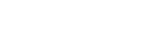

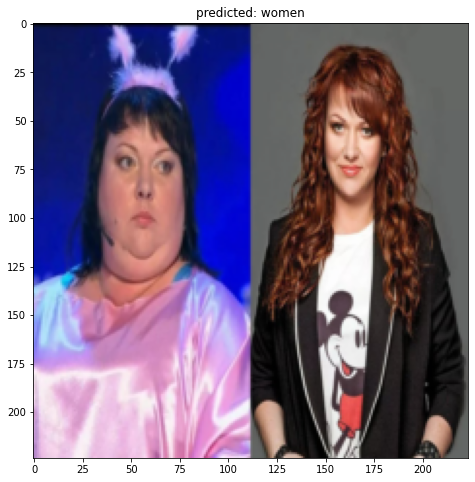

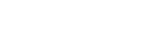

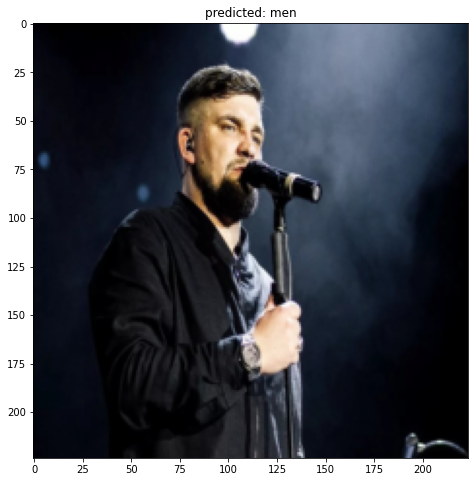

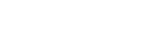

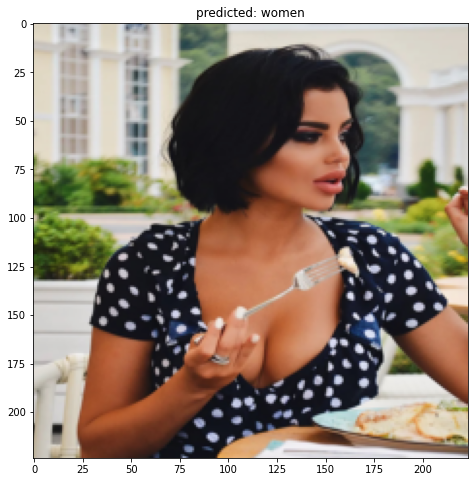

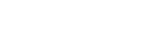

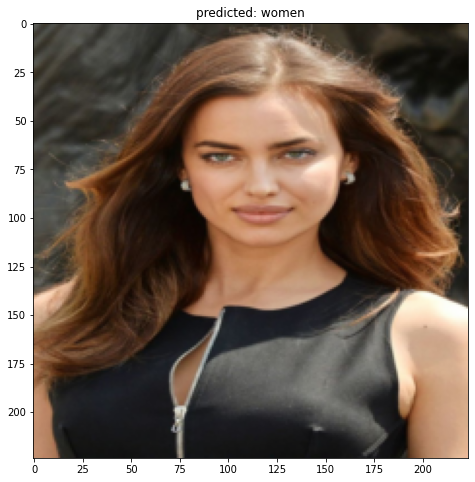

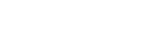

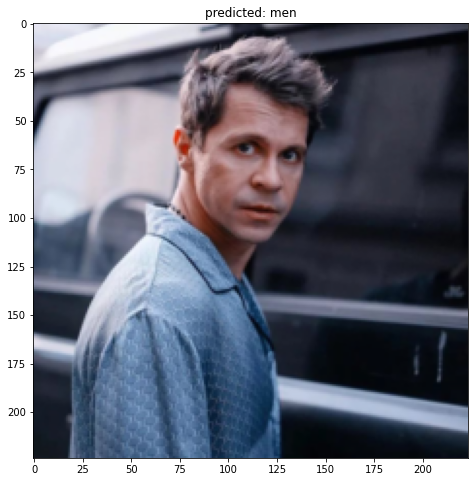

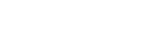

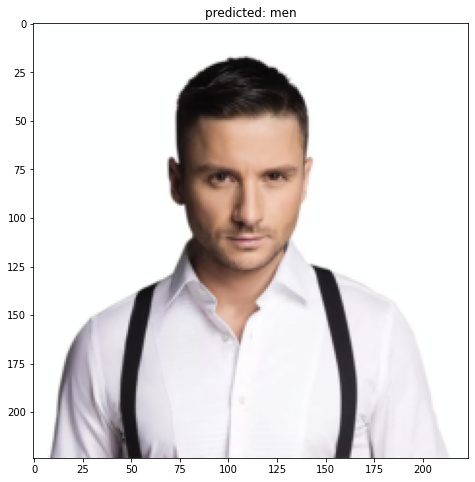

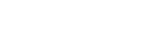

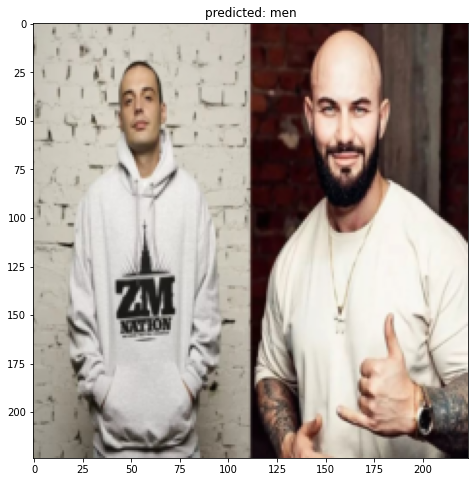

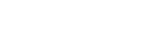

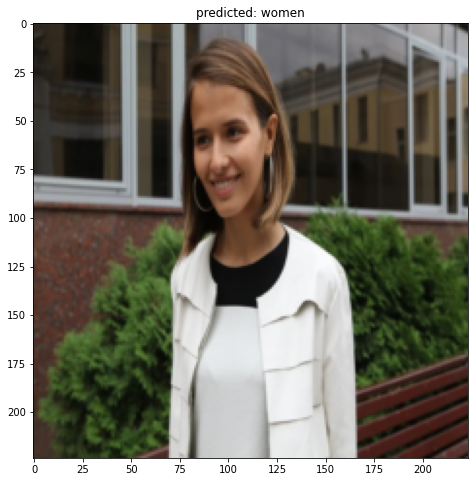

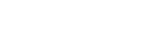

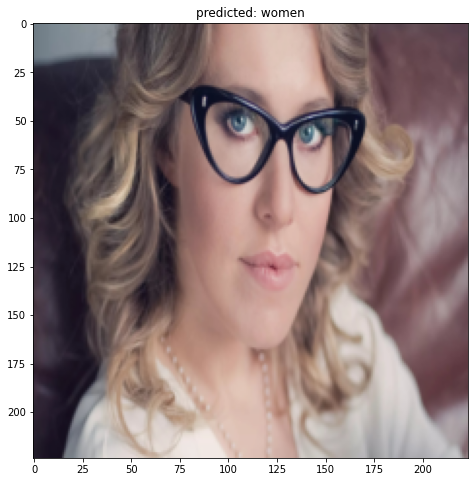

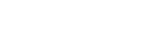

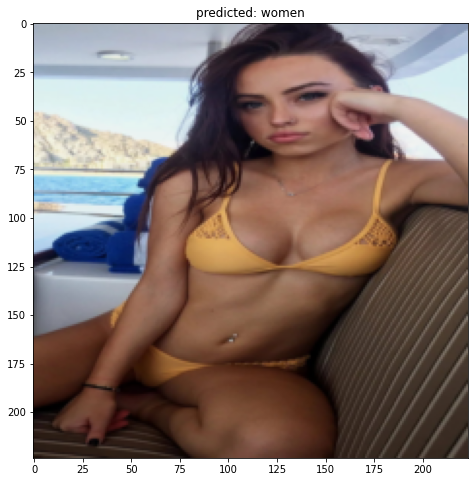

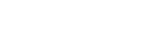

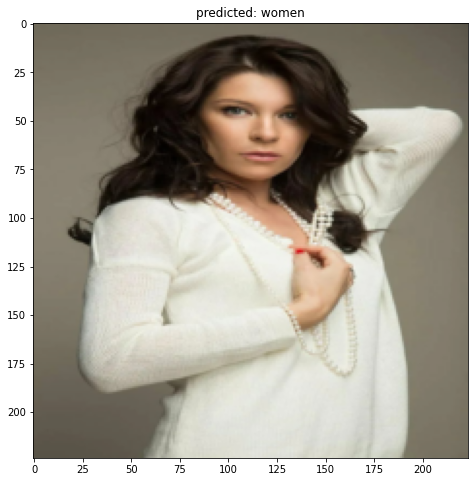

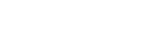

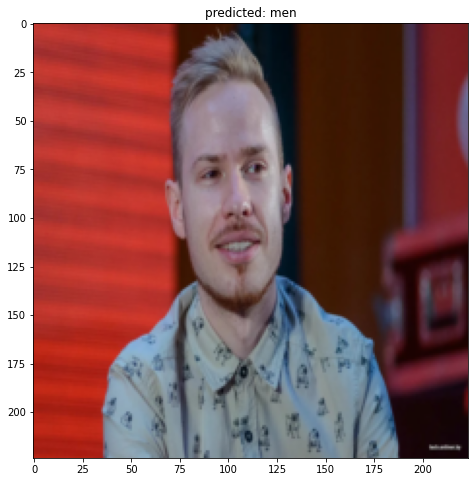

In [49]:
visualize_model(optimized_model)